<a href="https://colab.research.google.com/github/anujdutt9/Deep-Learning-TF-2.0/blob/master/TF_2_CNN_EMNIST_Classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# EMNIST Classification using CNN

In this notebook, we'll create a Convolutional Neural Network Model for classifying EMNIST [Extended MNIST] dataset consisting of digits as well as characters in English Language.

In [1]:
# Import Dependencies
%tensorflow_version 2.1
import tensorflow as tf
import tensorflow_datasets as tfds
import numpy as np
import seaborn as sn
import pandas as pd
import matplotlib.pyplot as plt

`%tensorflow_version` only switches the major version: 1.x or 2.x.
You set: `2.1`. This will be interpreted as: `2.x`.


TensorFlow 2.x selected.


In [0]:
# Download the Dataset with the split 80% Training, 20% Validation
(train_data, validation_data, test_data), info = tfds.load('emnist/balanced',
                                          split=['train[:80%]','train[80%:]','test'],
                                          with_info=True,
                                          as_supervised=True)

In [3]:
# Check Dataset Size
print("Number of samples in Training Dataset: ", len(list(train_data)))
print("Number of samples in Validation Dataset: ", len(list(validation_data)))
print("Number of samples in Test Dataset: ", len(list(test_data)))

Number of samples in Training Dataset:  90240
Number of samples in Validation Dataset:  22560
Number of samples in Test Dataset:  18800


In [4]:
# Check Dataset Downloaded Files
!ls /root/tensorflow_datasets/emnist/balanced/3.0.0

dataset_info.json		     emnist-train.tfrecord-00000-of-00001
emnist-test.tfrecord-00000-of-00001  image.image.json


# Inspect the Downloaded Dataset

In [5]:
info

tfds.core.DatasetInfo(
    name='emnist',
    version=3.0.0,
    description='The EMNIST dataset is a set of handwritten character digits derived from the NIST Special Database 19 and converted to a 28x28 pixel image format and dataset structure that directly matches the MNIST dataset.

Note: Like the original EMNIST data, images provided here are inverted horizontally and rotated 90 anti-clockwise. You can use `tf.transpose` within `ds.map` to convert the images to a human-friendlier format.',
    homepage='https://www.nist.gov/itl/products-and-services/emnist-dataset',
    features=FeaturesDict({
        'image': Image(shape=(28, 28, 1), dtype=tf.uint8),
        'label': ClassLabel(shape=(), dtype=tf.int64, num_classes=47),
    }),
    total_num_examples=131600,
    splits={
        'test': 18800,
        'train': 112800,
    },
    supervised_keys=('image', 'label'),
    citation="""@article{cohen_afshar_tapson_schaik_2017,
        title={EMNIST: Extending MNIST to handwritten lette

In [6]:
# Get the Features
info.features

FeaturesDict({
    'image': Image(shape=(28, 28, 1), dtype=tf.uint8),
    'label': ClassLabel(shape=(), dtype=tf.int64, num_classes=47),
})

In [7]:
# Get Size of Training and Test Data Samples
info.splits

{'test': <tfds.core.SplitInfo num_examples=18800>,
 'train': <tfds.core.SplitInfo num_examples=112800>}

# Data Preprocessing

In [0]:
# Normalize Dataset
def normalize_image(image, label):
  image = tf.cast(image, tf.float32)
  # Normalize the pixel values
  image = image / 255.0
  # Resize the image
  image = tf.image.resize(image, (28, 28))
  return image, label

In [0]:
# Normalize Training and Validation Data
train_data = train_data.map(normalize_image)
validation_data = validation_data.map(normalize_image)
test_data = test_data.map(normalize_image)

In [10]:
# Check sample Normalized Image Data and It's Shape
data = iter(train_data)
sample_image, label = next(data)
sample_image.numpy()

array([[[0.        ],
        [0.        ],
        [0.        ],
        [0.        ],
        [0.        ],
        [0.        ],
        [0.        ],
        [0.        ],
        [0.        ],
        [0.        ],
        [0.        ],
        [0.        ],
        [0.        ],
        [0.        ],
        [0.        ],
        [0.        ],
        [0.        ],
        [0.        ],
        [0.        ],
        [0.        ],
        [0.        ],
        [0.        ],
        [0.        ],
        [0.        ],
        [0.        ],
        [0.        ],
        [0.        ],
        [0.        ]],

       [[0.        ],
        [0.        ],
        [0.        ],
        [0.        ],
        [0.        ],
        [0.        ],
        [0.        ],
        [0.        ],
        [0.        ],
        [0.        ],
        [0.        ],
        [0.        ],
        [0.        ],
        [0.        ],
        [0.        ],
        [0.        ],
        [0.        ],
        

In [11]:
# Shape of Sample Image
sample_image.shape

TensorShape([28, 28, 1])

In [12]:
# Sample Data Label
label.numpy()

31

# Visualizing Dataset

In [0]:
# Plot some images from the Dataset
def plot_sample_image(data_split=None, data_batch_size=None):
  data = iter(train_data.batch(batch_size=data_batch_size))
  fig = plt.figure(figsize=(15,15))
  for i in range(data_batch_size):
    sample_image, label = data.next()
    img = sample_image[i].numpy()
    img = img.reshape(28,28)
    ax = fig.add_subplot(5, 4, i+1)
    plt.imshow(img, cmap='gray')
    title_text = 'Label: ' + str(label[i].numpy())
    plt.title(title_text)
    fig.tight_layout(pad=2.0)

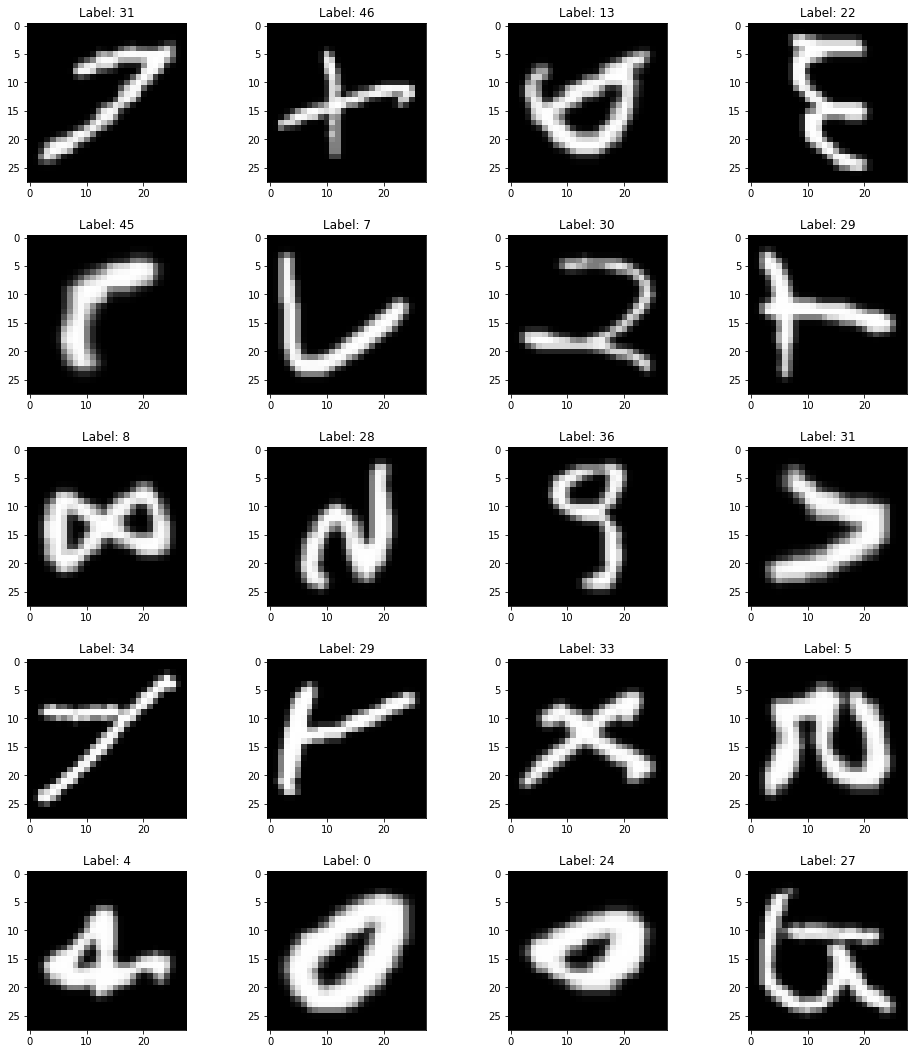

In [14]:
plot_sample_image(data_split=train_data, data_batch_size=20)

In [0]:
# Define Data Buffer Size and Batch Size
Buffer_Size = 1000
Batch_Size = 64

In [0]:
# Prepare dataset for Model Training
# Here we set the buffer size to 1000 i.e. at a time we randomly pick up 1000 reviews and fill the buffer with that.
# Then we take the data samples from dataset equal to batch size.
# Ref. https://www.tensorflow.org/api_docs/python/tf/data/Dataset#prefetch
# Training Data Batches
train_batches = train_data.shuffle(buffer_size=Buffer_Size).batch(Batch_Size).prefetch(tf.data.experimental.AUTOTUNE)

# Validation Data Batches
validation_batches = validation_data.shuffle(buffer_size=Buffer_Size).batch(Batch_Size).prefetch(tf.data.experimental.AUTOTUNE)

# Test Data Batches
test_batches = test_data.batch(Batch_Size).prefetch(tf.data.experimental.AUTOTUNE)

# Model Architecture

In [17]:
# ML Model Architecture
model = tf.keras.Sequential([tf.keras.layers.Input(shape=(28,28,1)),
                             tf.keras.layers.Conv2D(filters=32, kernel_size=(3,3), activation='relu'),
                             tf.keras.layers.MaxPool2D(pool_size=(2,2)),
                             tf.keras.layers.Conv2D(filters=64, kernel_size=(3,3), activation='relu'),
                             tf.keras.layers.MaxPool2D(pool_size=(2,2)),
                             tf.keras.layers.Conv2D(filters=128, kernel_size=(3,3), activation='relu'),
                             tf.keras.layers.Dropout(rate=0.5),
                             tf.keras.layers.Flatten(),
                             tf.keras.layers.Dense(units=128, activation='relu'),
                             tf.keras.layers.Dense(units=info.features['label'].num_classes, activation='softmax')
])

# Print Model Summary
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 26, 26, 32)        320       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 13, 13, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 11, 11, 64)        18496     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 5, 5, 64)          0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 3, 3, 128)         73856     
_________________________________________________________________
dropout (Dropout)            (None, 3, 3, 128)         0         
_________________________________________________________________
flatten (Flatten)            (None, 1152)              0

In [0]:
# Compile the Model
model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

In [19]:
# Training Epochs
Epochs = 10

# Validation Steps
valid_steps = 20

# Train the Model
hist = model.fit(train_batches,
                 epochs= Epochs,
                 validation_data= validation_batches,
                 validation_steps= valid_steps)

Epoch 1/10
1410/1410 [==============================] - 27s 19ms/step - loss: 0.8930 - accuracy: 0.7239 - val_loss: 0.4045 - val_accuracy: 0.8539
Epoch 2/10
1410/1410 [==============================] - 24s 17ms/step - loss: 0.4869 - accuracy: 0.8307 - val_loss: 0.3724 - val_accuracy: 0.8570
Epoch 3/10
1410/1410 [==============================] - 24s 17ms/step - loss: 0.4277 - accuracy: 0.8505 - val_loss: 0.3521 - val_accuracy: 0.8687
Epoch 4/10
1410/1410 [==============================] - 24s 17ms/step - loss: 0.3934 - accuracy: 0.8577 - val_loss: 0.3371 - val_accuracy: 0.8797
Epoch 5/10
1410/1410 [==============================] - 24s 17ms/step - loss: 0.3662 - accuracy: 0.8677 - val_loss: 0.3081 - val_accuracy: 0.8875
Epoch 6/10
1410/1410 [==============================] - 24s 17ms/step - loss: 0.3501 - accuracy: 0.8718 - val_loss: 0.2810 - val_accuracy: 0.8984
Epoch 7/10
1410/1410 [==============================] - 24s 17ms/step - loss: 0.3368 - accuracy: 0.8746 - val_loss: 0.2918 -

# Trained Model Metrics

In [0]:
# Get the Trained Model Metrics
history_dict = hist.history

acc = history_dict['accuracy']
val_acc = history_dict['val_accuracy']
loss=history_dict['loss']
val_loss=history_dict['val_loss']

epochs = range(1, len(acc) + 1)

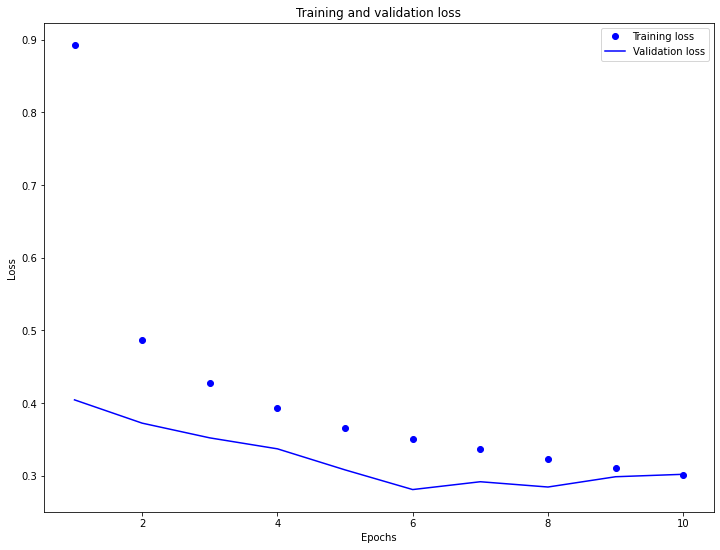

In [21]:
# Plot Training and Validation Loss
plt.figure(figsize=(12,9))
plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

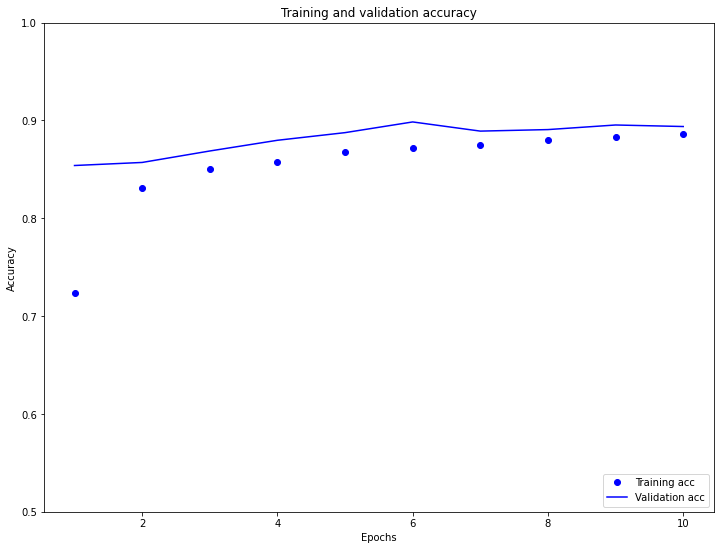

In [22]:
# Plot Training and Validation Accuracy
plt.figure(figsize=(12,9))
plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')
plt.ylim((0.5,1))
plt.show()

In [0]:
# Save Trained Model
model.save('emnist_cnn.h5')
model.save_weights('emnist_cnn_weights.h5')

# Trained Model Evaluation

Evaluating Trained model on Test dataset.

In [0]:
# Get Model Predictions on Test Dataset
predictions = model.predict(test_batches)

# Predicted Classes
predicted_labels = np.argmax(predictions, axis=1)

# True Labels for Test Data
true_labels = []
for _, label in test_batches:
  for vals in label.numpy():
    true_labels.append(vals)

In [0]:
from sklearn.metrics import classification_report, confusion_matrix

In [0]:
# Confusion Matrix
conf_matrix = confusion_matrix(true_labels, predicted_labels)

In [27]:
# Model Classification Performance Report
print(classification_report(true_labels, predicted_labels))

              precision    recall  f1-score   support

           0       0.61      0.86      0.71       400
           1       0.55      0.73      0.63       400
           2       0.94      0.86      0.90       400
           3       0.99      0.98      0.99       400
           4       0.91      0.95      0.93       400
           5       0.95      0.88      0.91       400
           6       0.95      0.92      0.93       400
           7       0.96      0.99      0.97       400
           8       0.93      0.96      0.94       400
           9       0.63      0.94      0.76       400
          10       0.97      0.98      0.98       400
          11       0.97      0.96      0.97       400
          12       0.97      0.94      0.96       400
          13       0.92      0.95      0.93       400
          14       0.97      0.99      0.98       400
          15       0.73      0.53      0.61       400
          16       0.96      0.94      0.95       400
          17       0.97    

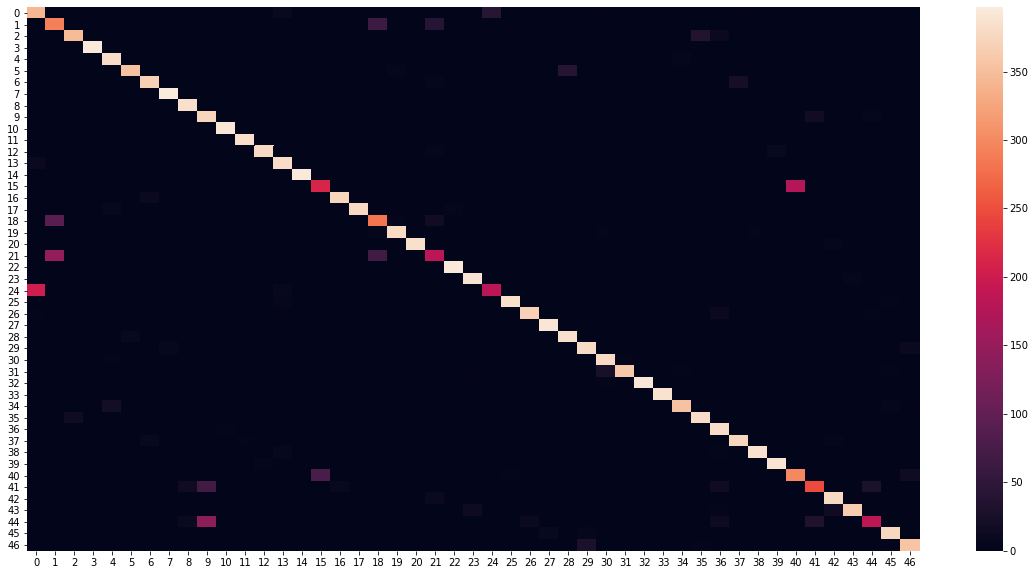

In [28]:
# Plot Confusion Matrix for the Model
df_cm = pd.DataFrame(conf_matrix, range(47), range(47))
plt.figure(figsize=(20,10))
sn.heatmap(df_cm)
plt.show()

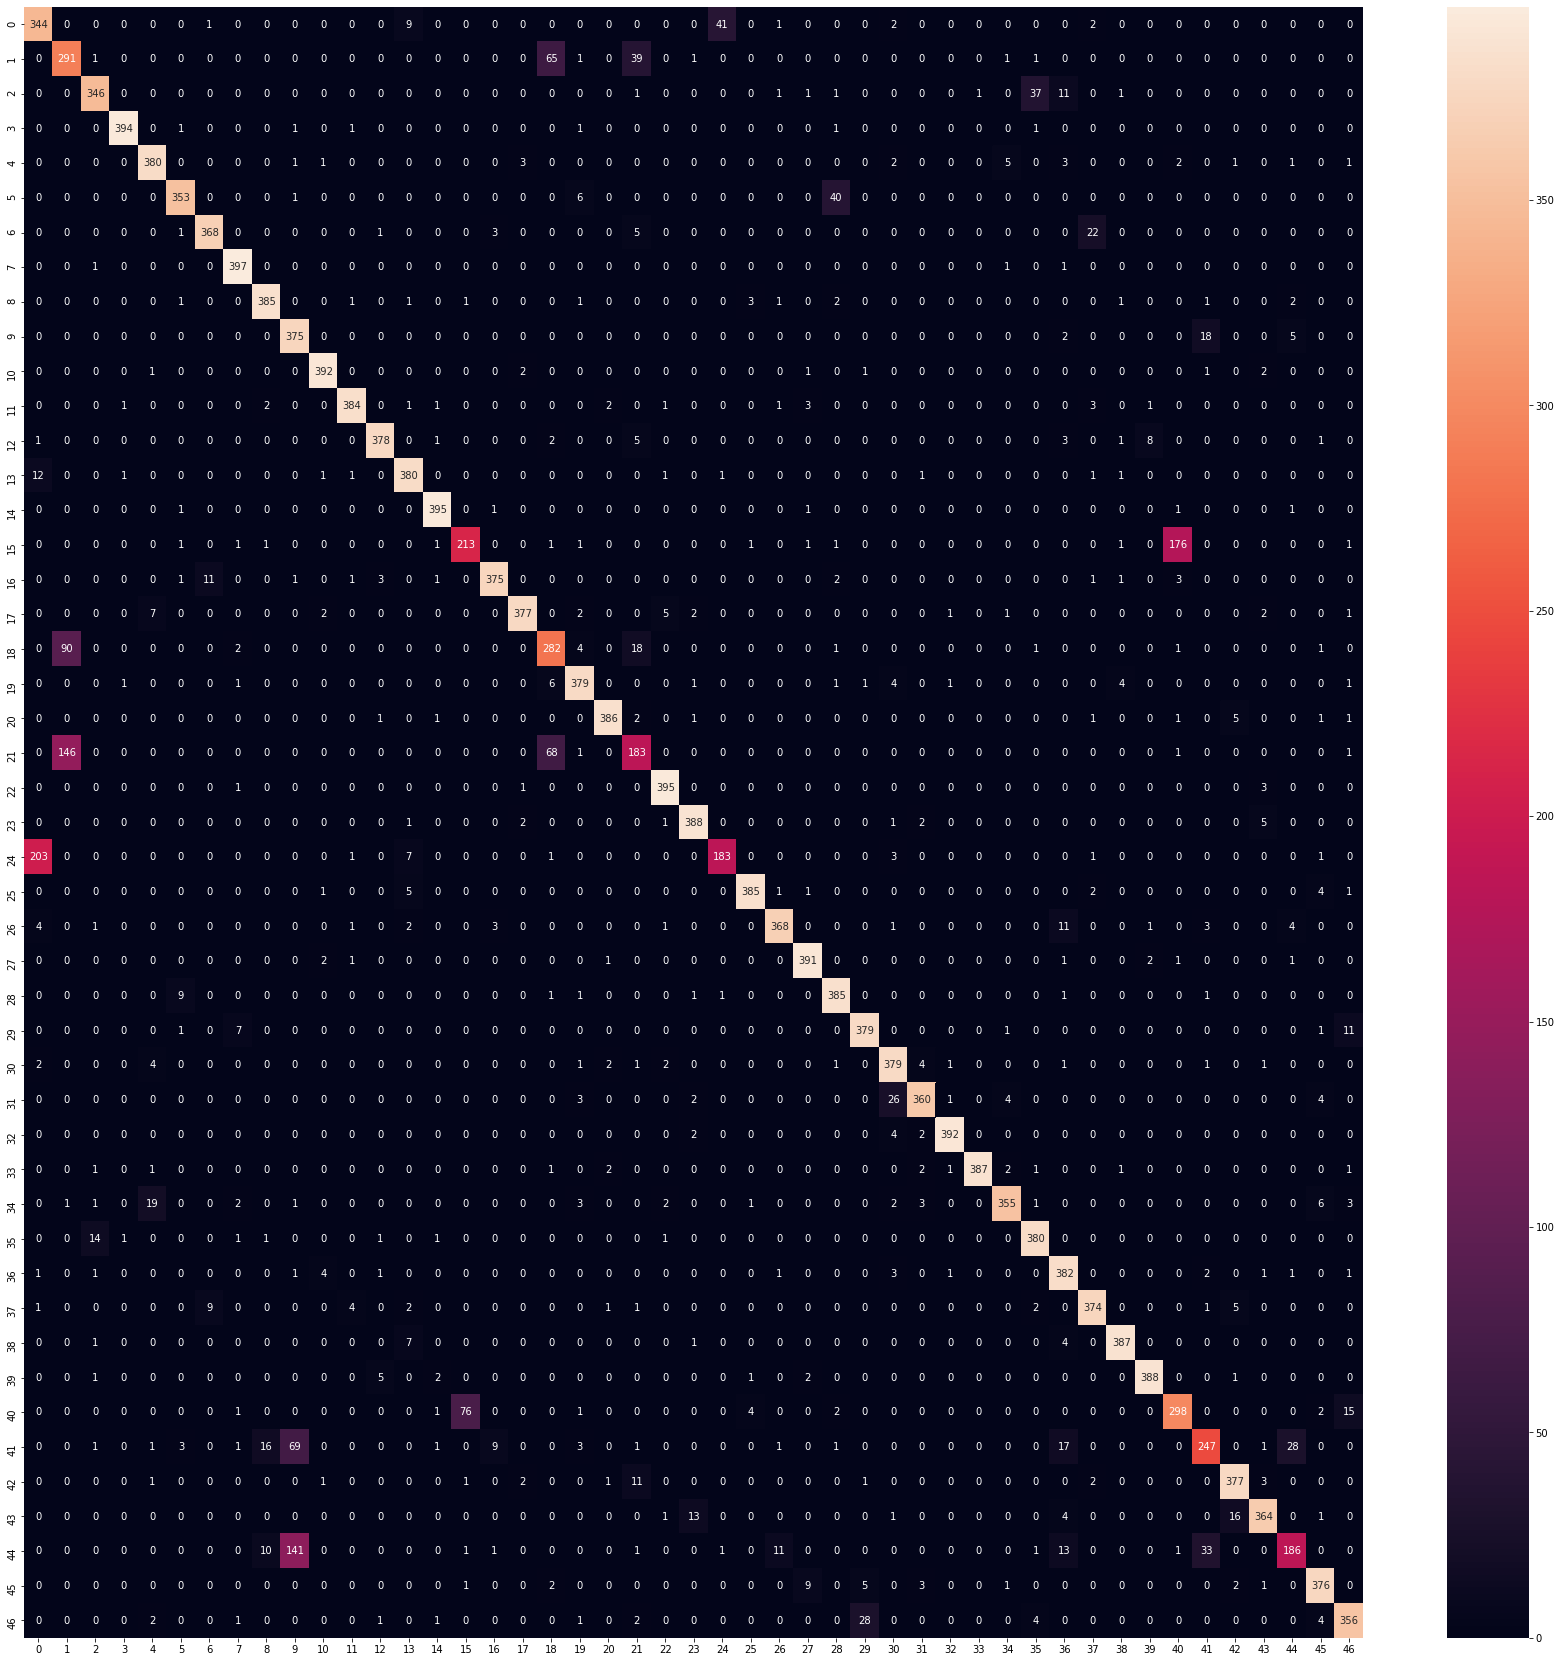

In [29]:
# Confusion Matrix with dominant Values per Label
plt.figure(figsize=(30,30))
sn.heatmap(df_cm, annot=True, fmt="d")
plt.show()

# Plot of Predicted Label vs Original Label

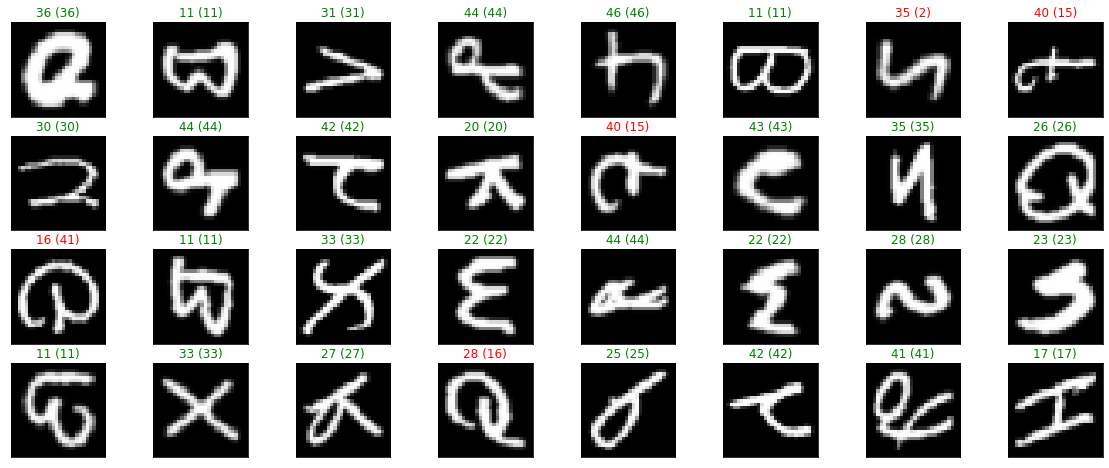

In [31]:
# Get sample images from Test Dataset
test_image_data = test_batches.take(1)

# Get Model Predictions for the Test Dataset
test_pred = model.predict(test_image_data)
test_plot_pred_labels = np.argmax(test_pred, axis=1)

# Plot the Images with Actual and Predicted Labels
fig = plt.figure(figsize=(20, 8))

for sample in test_image_data:
  img, label = sample[0].numpy(), sample[1].numpy()

  for i in range(32):
    ax = fig.add_subplot(4, 8, i+1, xticks=[], yticks=[])
    ax.imshow(np.squeeze(img[i]), cmap='gray')
    pred_idx = test_plot_pred_labels[i]
    true_idx = label[i]
    ax.set_title("{} ({})".format(pred_idx, true_idx),
                  color=("green" if pred_idx == true_idx else "red"))